In [1]:
"""
Created on Tue Jun 24 18:42:10 2025

@author: Alexander Merrington
"""

"""
Importing libraries
"""
import os    # a module that allows us to "talk" with our operating system, necessary for handling paths, files and so on
from glob import glob # a module that allows the use of the wildcard (*) for searching for specific filename patterns in directories
import specdal as spec # a module for handling field spectrometer data
import pandas as pd   # Pandas is a powerful module for the handling of data sets
from matplotlib import pyplot as plt   # matplotlib emulates the functions of MATLAB. Here, we tell matplotlib to only import one of it's functions, the pyplot function, and to import it with the identifier 'plt'
from scipy.signal import savgol_filter   # We will use this to smooth our data
import numpy as np # We require numpy for integration functions that will be used during convolution

In [8]:
"""
Options for processing
"""
sensor              = 'svc' # can be 'svc', 'asd' or 'psr'
fn_format           = '14deg*' # if not used, keep blank i.e. '' so length = 0 '14deg*'
interpolate         = True
water_band_removal  = False
water_band_interp   = False
sig_smooth          = False
csv_needed          = True

<class 'list'>

name:		14deg_plot_1101.0000,
measure_type:	pct_reflect
measurements:	wave  |measurement
		------|-----------
		 339.7|0.028
		   ...|...
		2513.2|0.125
metadata:	file:C:\Users\zhalem\Documents\ASD_data\PANGEOS_NO_2025\SVC_data\canopy_level_indoor\14deg_plot_1101.0000.sig
		instrument_type:SIG
		integration_time:36.666666666666664
		measurement_type:Counts
		gps_time_ref:100158.0
		gps_time_tgt:100246.0
		wavelength_range:(np.float64(339.7), np.float64(2513.2))


name:		14deg_plot_1101.0001,
measure_type:	pct_reflect
measurements:	wave  |measurement
		------|-----------
		 339.7|0.024
		   ...|...
		2513.2|0.700
metadata:	file:C:\Users\zhalem\Documents\ASD_data\PANGEOS_NO_2025\SVC_data\canopy_level_indoor\14deg_plot_1101.0001.sig
		instrument_type:SIG
		integration_time:76.66666666666667
		measurement_type:Counts
		gps_time_ref:100505.0
		gps_time_tgt:100524.0
		wavelength_range:(np.float64(339.7), np.float64(2513.2))


name:		14deg_plot_1101.0002,
measure_type:	pct_refl

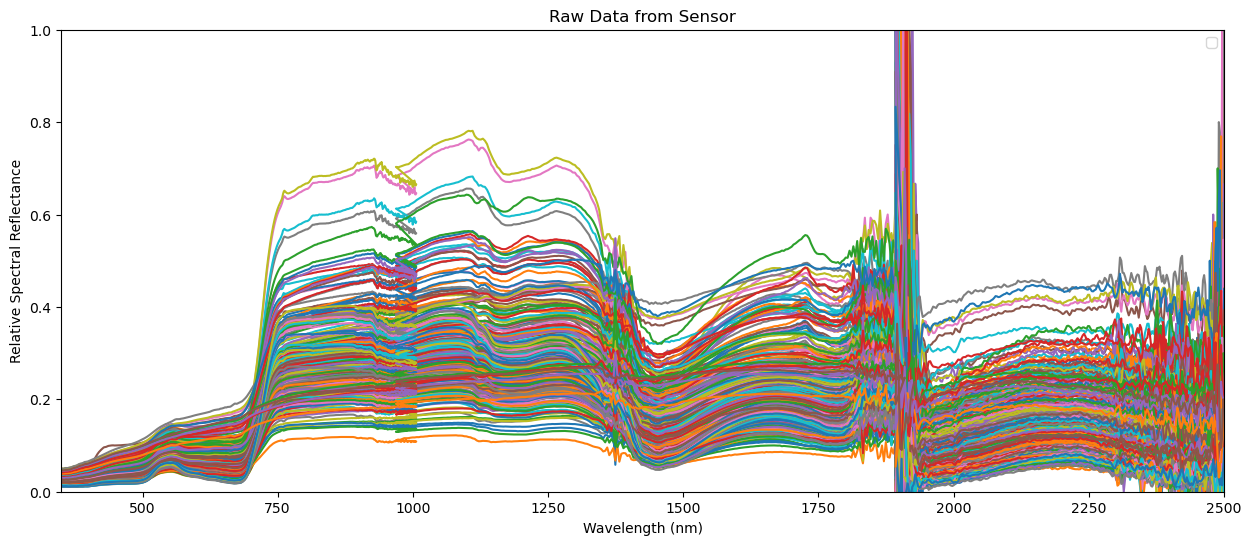

In [9]:
"""
Importing data
"""

### Data import
if sensor == 'svc':
    in_dir = '/Users/zhalem/Documents/ASD_data/PANGEOS_NO_2025/SVC_data/canopy_level_indoor/'
if sensor == 'asd':
    in_dir = '/Users/zoehalem/Downloads/PANGEOS/PANGEOS_NO_2025/ASD_data/'

### White reference panel directory    
ref_panel_dir = '/Users/zhalem/Documents/ASD_data/PANGEOS_NO_2025/calibration_script_example_with_data/'

### Either importing a specific filename pattern or every file in a directory.
if len(fn_format) > 0:
    data = spec.Collection(name='data')
    for file in glob(in_dir + fn_format):
        spectrum = spec.Spectrum(filepath=os.path.join(in_dir, file))
        data.append(spectrum)
else:
    data = spec.Collection(name='data', directory = in_dir)

### Sense check on data
print(type(data.spectra))
for s in data.spectra[0:3]:
    print(s)
data.data.head(3)

data.plot(title='Raw Data from Sensor', figsize=(15, 6), ylim=(0, 1),xlim=(350, 2500))
plt.legend('')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Reflectance")
plt.show()


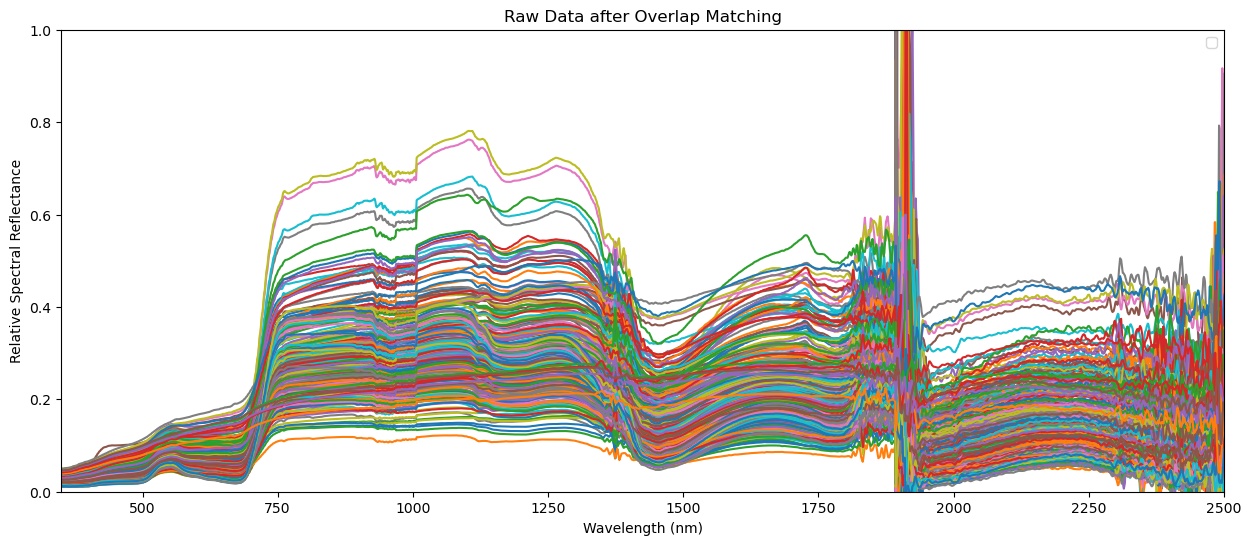

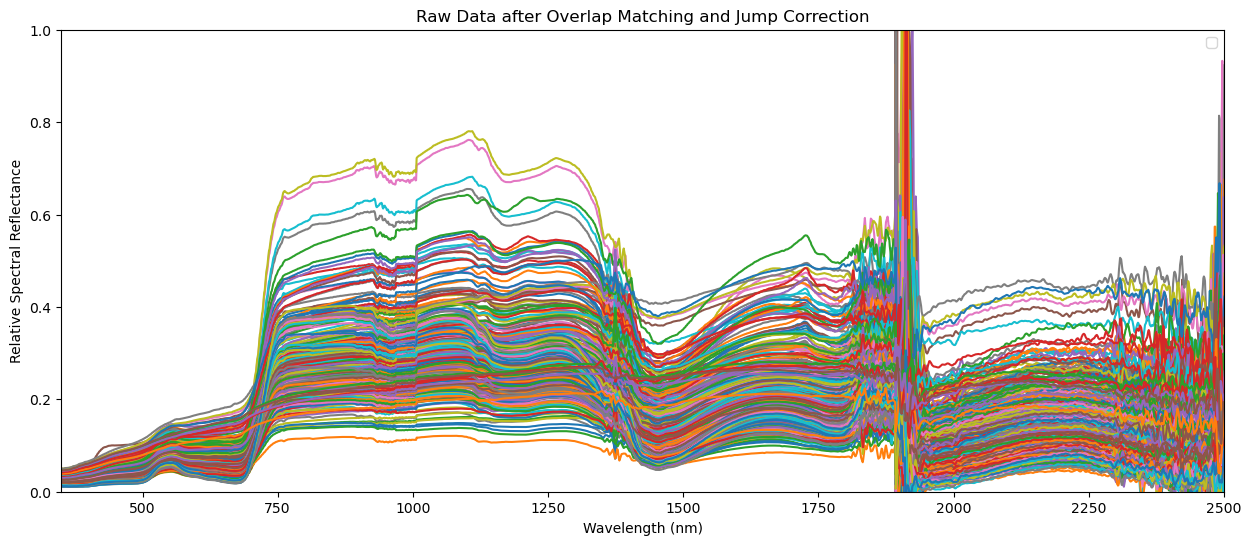

In [10]:
"""
Overlap matching and jump correction
"""
### 1nm interpolation if chosen
if interpolate == True:
    data.interpolate(spacing=1, method='linear')
    
### Overlap matching or 'stitching'
if sensor == 'svc':
    data.stitch(method='mean')
    
    data.plot(title='Raw Data after Overlap Matching', figsize=(15, 6), ylim=(0, 1),xlim=(350, 2500))
    plt.legend('')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Relative Spectral Reflectance")
    plt.show()
    
    ### Jump correction
    data.jump_correct(splices=[980,1880], reference=0)
    
    data.plot(title='Raw Data after Overlap Matching and Jump Correction', figsize=(15, 6), ylim=(0, 1),xlim=(350, 2500))
    plt.legend('')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Relative Spectral Reflectance")
    plt.show() 

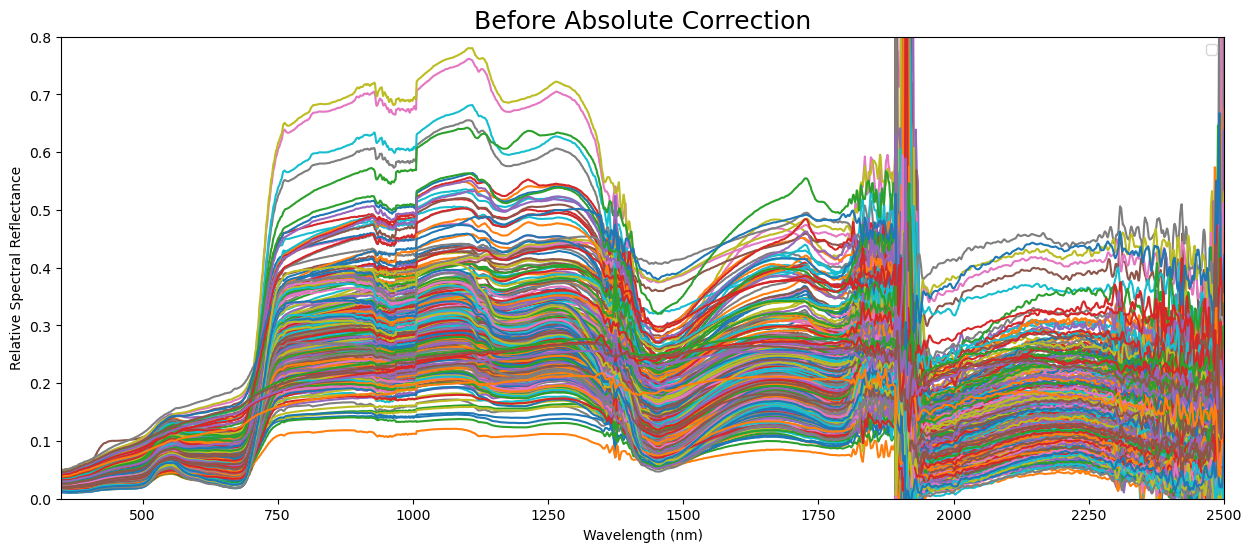

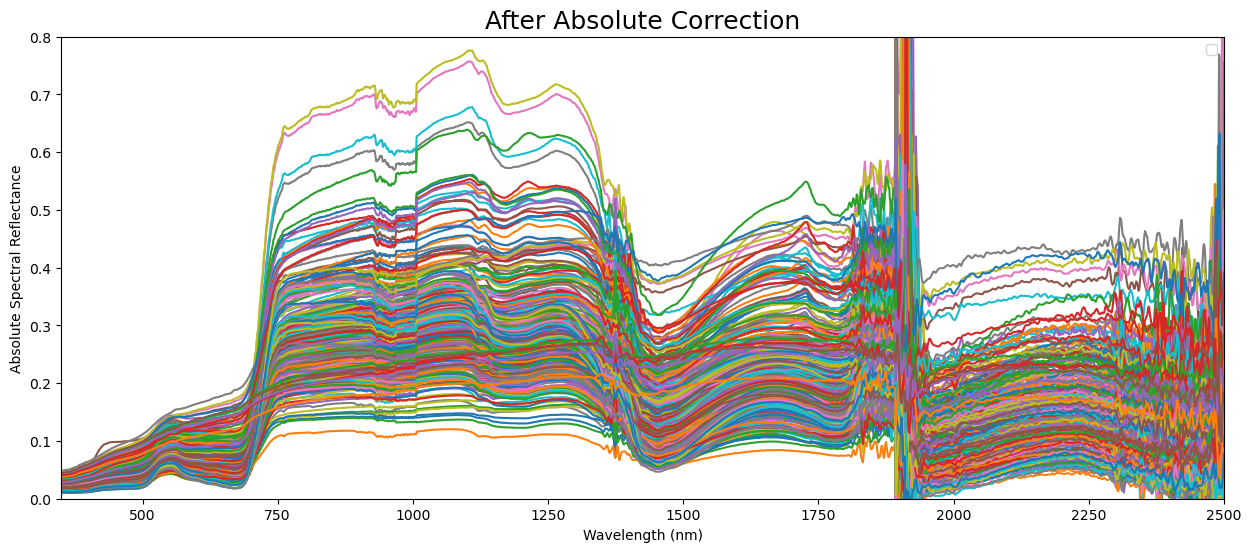

In [13]:
"""
Correcting to absolute reflectance
"""
data.plot(title='Data', figsize=(15, 6), ylim=(0, 0.8),xlim=(350, 2500))
plt.title('Before Absolute Correction', fontsize=18)
plt.legend('')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Reflectance")
plt.show()

### Read in reference panel reflectance per wavelength
reference_panel = pd.read_csv(ref_panel_dir+'SRT071_20250714.csv', index_col = "Wavelength")
ref_abs = data.data.mul(reference_panel['Absolute Reflectance'], axis = 0)

### Removing bands that are not reliably corrected to absolute reflectance (i.e. removing pre 350 wavelengths, and post 2500)
ref_abs = ref_abs.loc[350:2500] #remember to change variable name

ref_abs.plot(title='Data', figsize=(15, 6), ylim=(0, 0.8),xlim=(350, 2500))
plt.title('After Absolute Correction', fontsize=18)
plt.legend('')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absolute Spectral Reflectance")
plt.show()

In [15]:
### Removing bands that are not reliably corrected to absolute reflectance (i.e. removing pre 350 wavelengths, and post 2500)
### Read in reference panel reflectance per wavelength
reference_panel = pd.read_csv(ref_panel_dir+'SRT071_20250714.csv', index_col = "Wavelength")
ref_abs = data.data.mul(reference_panel['Absolute Reflectance'], axis = 0)

ref_abs = ref_abs.loc[350:2500] #remember to change variable name

In [16]:
"""
Smoothing signal if required and appropriate
"""
### Smoothing signal with Savitsky-Golay filter
if sig_smooth == True:
    window_size = 21
    polynomial_used = 1
    ref_abs = pd.DataFrame(savgol_filter(data.data, window_size, polynomial_used, axis=0, mode='interp'), columns=data.data.columns, index=data.data.index)

    ref_abs.plot(title='Data', figsize=(15, 6), ylim=(0, 0.6),xlim=(350, 2500))
    plt.title('After Smoothing', fontsize=18)
    plt.legend('')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absolute Spectral Reflectance")
    plt.show()

In [17]:
"""
Removing water absorption bands (only for nadir data using the sun for illumination)
"""
### Removing water bands if needed
if water_band_removal == True:
    ref_abs.loc[1350:1400] = 99 #might want to keep this as not too bad! RR
    ref_abs.loc[1770:1950] = 99
    ref_abs.replace(99,np.nan, inplace= True)
    if water_band_interp == True:
        ref_abs.interpolate(method='linear', axis=0, inplace = True)
    ref_abs.plot(title='Absolute Data with Water Bands Removed', figsize=(15, 6), ylim=(0, 0.6),xlim=(350, 2500))
    plt.legend('')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absolute Spectral Reflectance")
    plt.show() 

In [18]:
"""
If the files are SVC (.sig) files, changing the dot notation to an '_' at the end of the files name (e.g. plot1.0000, plot1.0001)
so that repeat measurements can be grouped for easy averaging.
"""
if sensor == 'svc':
    ref_abs.columns = ref_abs.columns.str.replace('.','_')
    print(ref_abs.columns)

Index(['14deg_plot_1101_0000', '14deg_plot_1101_0001', '14deg_plot_1101_0002',
       '14deg_plot_1101_0003', '14deg_plot_1101_0004', '14deg_plot_1102_0000',
       '14deg_plot_1102_0001', '14deg_plot_1102_0002', '14deg_plot_1102_0003',
       '14deg_plot_1103_0000 (2)',
       ...
       '14deg_plot_1810_0000', '14deg_plot_1810_0001', '14deg_plot_1810_0002',
       '14deg_plot_1810_0003', '14deg_plot_1810_0004', '14deg_plot_soil_0000',
       '14deg_plot_soil_0001', '14deg_plot_soil_0002', '14deg_plot_soil_0003',
       '14deg_plot_soil_0004'],
      dtype='object', length=376)


In [23]:
"""
Choosing groupings for data
"""
### Reforming the SpecDal Collection object
ref_abs = ref_abs.transpose()   #!!! need to get file names as the index and/or a metadata attribute coppied over from the original collection
data_corrected = spec.df_to_collection(ref_abs, name='Corrected_Data')

### Grouping the data by the second underscore separator and printing the names the data can be grouped by
groups = data_corrected.groupby(separator='_', indices=[2,])
group_names = list(groups.keys())
print(group_names)

['1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '1110', '1207', '1208', '1210', '1304', '1305', '1310', '1401', '1402', '1403', '1404', '1405', '1406', '1407', '1408', '1409', '1410', '1501', '1502', '1503', '1504', '1505', '1506', '1507', '1508', '1510', '1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1701', '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1807', '1810', 'soil']


In [27]:
"""
Save to csv
"""
out_dir = '/Users/zhalem/Documents/ASD_data/PANGEOS_NO_2025/csv_exports/'
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, f"{data_corrected.name}_all_spectra.csv")
ref_abs.to_csv(out_path)

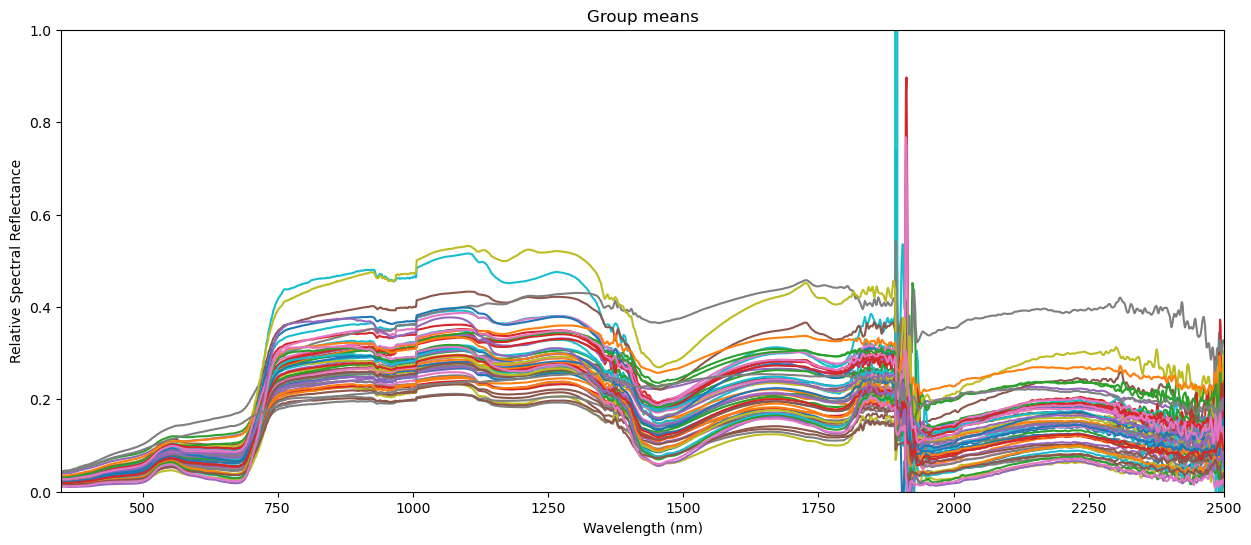

In [30]:
# average of each plot
from specdal import Collection
means = Collection(name='means')
for group_key, group_collection in groups.items():
 means.append(group_collection.mean())
means.plot(title='Group means', figsize=(15, 6), ylim=(0, 1),xlim=(350, 2500), legend=False)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Reflectance")
plt.show()

In [29]:
"""
Save to csv
"""
out_dir = '/Users/zhalem/Documents/ASD_data/PANGEOS_NO_2025/csv_exports/'
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, f"{data_corrected.name}_group_means.csv")
means.to_csv(out_path)